In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [27]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
import datetime
import nltk

In [3]:
def create_summary_writer(log_dir):
    return tf.summary.create_file_writer(logdir=log_dir)

In [4]:
HP_MODEL = hp.HParam('model', hp.Discrete(['Random Forest', 'SVM', 'Logistic Regression', 'SGD Classifier', 'Naive Bayes', 'K Nearest Neighbors', 'Decision Tree']))
HP_TRAIN_SIZE = hp.HParam('train_size', hp.RealInterval(0.0, 1.0))


In [5]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
with tf.summary.create_file_writer(log_dir).as_default():
    hp.hparams_config(
        hparams=[HP_MODEL, HP_TRAIN_SIZE],
        metrics=[hp.Metric('accuracy', display_name='Accuracy')],
    )

In [8]:
# Data Loading
Psy = pd.read_csv("C:/Users/goura/Downloads/archive (23)/Youtube01-Psy.csv")
Katy = pd.read_csv("C:/Users/goura/Downloads/archive (23)/Youtube02-KatyPerry.csv")
Eminem = pd.read_csv("C:/Users/goura/Downloads/archive (23)/Youtube04-Eminem.csv")
Shakira = pd.read_csv("C:/Users/goura/Downloads/archive (23)/Youtube05-Shakira.csv")
LMFAO = pd.read_csv("C:/Users/goura/Downloads/archive (23)/Youtube03-LMFAO.csv")
df = pd.concat([Shakira, Eminem, Katy, Psy, LMFAO])

In [11]:
df.columns

Index(['COMMENT_ID', 'AUTHOR', 'DATE', 'CONTENT', 'CLASS'], dtype='object')

In [12]:
df.drop('DATE', axis=1, inplace=True)

df.shape

(1956, 4)

In [13]:
df.columns

Index(['COMMENT_ID', 'AUTHOR', 'CONTENT', 'CLASS'], dtype='object')

In [14]:
df.head()

,COMMENT_ID,AUTHOR,CONTENT,CLASS
0,z13lgffb5w3ddx1ul22qy1wxspy5cpkz504,dharma pal,Nice song﻿,0
1,z123dbgb0mqjfxbtz22ucjc5jvzcv3ykj,Tiza Arellano,I love song ﻿,0
2,z12quxxp2vutflkxv04cihggzt2azl34pms0k,Prìñçeśś Âliś Łøvê Dømíñø Mâđiś™ ﻿,I love song ﻿,0
3,z12icv3ysqvlwth2c23eddlykyqut5z1h,Eric Gonzalez,"860,000,000 lets make it first female to reach...",0
4,z133stly3kete3tly22petvwdpmghrlli,Analena López,shakira is best for worldcup﻿,0


<Axes: >

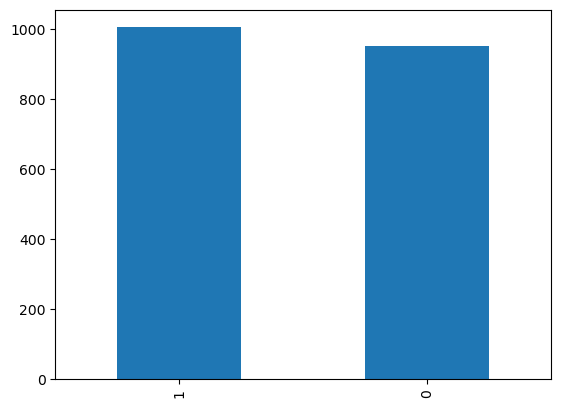

In [19]:
df['CLASS'].value_counts().plot(kind='bar')

In [20]:
classes = df['CLASS']
print(classes.value_counts())

1    1005
0     951
Name: CLASS, dtype: int64


In [21]:
text_messages = df["CONTENT"]

In [22]:
# Preprocessing
# Replace email addresses, URLs, phone numbers, other numbers, symbols, and remove stop words
processed = df['CONTENT'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')
processed = processed.str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')
processed = processed.str.replace(r'£|\$', 'moneysymb')
processed = processed.str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phonenumbr')
processed = processed.str.replace(r'\d+(\.\d+)?', 'numbr')
processed = processed.str.replace(r'[^\w\d\s]', ' ')
processed = processed.str.replace(r'\s+', ' ')
processed = processed.str.replace(r'^\s+|\s+?$', '')
processed = processed.str.lower()

C:\Users\goura\AppData\Local\Temp\ipykernel_19840\3240830285.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  processed = df['CONTENT'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')
C:\Users\goura\AppData\Local\Temp\ipykernel_19840\3240830285.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  processed = processed.str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')
C:\Users\goura\AppData\Local\Temp\ipykernel_19840\3240830285.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  processed = processed.str.replace(r'£|\$', 'moneysymb')
C:\Users\goura\AppData\Local\Temp\ipykernel_19840\3240830285.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  processed = processed.str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phonenumbr')
C:\Users\goura\

In [23]:
print(text_messages[:10])

0                                           Nice song﻿
1                                        I love song ﻿
2                                        I love song ﻿
3    860,000,000 lets make it first female to reach...
4                        shakira is best for worldcup﻿
5                    The best world cup song ever!!!!﻿
6                                              I love﻿
7    SEE SOME MORE SONG OPEN GOOGLE AND TYPE Shakir...
8                                            Awesome ﻿
9                                    I like shakira..﻿
Name: CONTENT, dtype: object


In [24]:
processed = processed.str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
processed = processed.str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
processed = processed.str.replace(r'^\s+|\s+?$', '')

C:\Users\goura\AppData\Local\Temp\ipykernel_19840\2241229190.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  processed = processed.str.replace(r'[^\w\d\s]', ' ')
C:\Users\goura\AppData\Local\Temp\ipykernel_19840\2241229190.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  processed = processed.str.replace(r'\s+', ' ')
C:\Users\goura\AppData\Local\Temp\ipykernel_19840\2241229190.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  processed = processed.str.replace(r'^\s+|\s+?$', '')


In [25]:
print(text_messages[:10])

0                                           Nice song﻿
1                                        I love song ﻿
2                                        I love song ﻿
3    860,000,000 lets make it first female to reach...
4                        shakira is best for worldcup﻿
5                    The best world cup song ever!!!!﻿
6                                              I love﻿
7    SEE SOME MORE SONG OPEN GOOGLE AND TYPE Shakir...
8                                            Awesome ﻿
9                                    I like shakira..﻿
Name: CONTENT, dtype: object


In [26]:
processed = processed.str.lower()
print(processed)

0                                              nice song
1                                            i love song
2                                            i love song
3      numbr numbr numbr lets make it first female to...
4                           shakira is best for worldcup
                             ...                        
433                      like this comment for no reason
434                                       love this song
435    this song is awesome these guys are the best l...
436          how many thumbs up for louis saving the day
437                                           nice numbr
Name: CONTENT, Length: 1956, dtype: object


In [28]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
processed = processed.apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

# Stemming
nltk.download('punkt')
ps = nltk.PorterStemmer()
processed = processed.apply(lambda x: ' '.join(ps.stem(term) for term in x.split()))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\goura\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\goura\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [29]:
# Preparing the final dataset
df['Processed_Content'] = processed
classes = df['CLASS']

print(df.head())

                              COMMENT_ID                              AUTHOR  \
0    z13lgffb5w3ddx1ul22qy1wxspy5cpkz504                          dharma pal   
1      z123dbgb0mqjfxbtz22ucjc5jvzcv3ykj                       Tiza Arellano   
2  z12quxxp2vutflkxv04cihggzt2azl34pms0k  Prìñçeśś Âliś Łøvê Dømíñø Mâđiś™ ﻿   
3      z12icv3ysqvlwth2c23eddlykyqut5z1h                       Eric Gonzalez   
4      z133stly3kete3tly22petvwdpmghrlli                       Analena López   

                                             CONTENT  CLASS  \
0                                         Nice song﻿      0   
1                                      I love song ﻿      0   
2                                      I love song ﻿      0   
3  860,000,000 lets make it first female to reach...      0   
4                      shakira is best for worldcup﻿      0   

                                   Processed_Content  
0                                          nice song  
1                             

In [30]:
# Tokenization
from nltk.tokenize import word_tokenize

# Create a bag-of-words model
all_words = []
for message in processed:
    words = word_tokenize(message)
    for w in words:
        all_words.append(w)
        
all_words = nltk.FreqDist(all_words)

In [34]:
# Use the most common words as features
word_features = list(all_words.keys())[:1500]

def find_features(message):
    words = word_tokenize(message)
    features = {}
    for word in word_features:
        features[word] = (word in words)

    return features

# Applying the find_features function to each SMS message
featuresets = [(find_features(text), label) for (text, label) in zip(df['Processed_Content'], classes)]

In [35]:
# Split the data into training and testing datasets
seed = 1
np.random.seed = seed
np.random.shuffle(featuresets)

training, testing = model_selection.train_test_split(featuresets, test_size=0.25, random_state=seed)

In [36]:
# print the total number of words and the 15 most common words
print('Number of words: {}'.format(len(all_words)))
print('Most common words: {}'.format(all_words.most_common(15)))

Number of words: 3472
Most common words: [('numbr', 1133), ('check', 581), ('video', 386), ('song', 340), ('com', 284), ('subscrib', 277), ('like', 272), ('youtub', 272), ('br', 258), ('pleas', 249), ('http', 236), ('love', 220), ('channel', 200), ('music', 157), ('make', 139)]


In [39]:
pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/24/ec/ad387100fa3cc2b9b81af0829b5ecfe75ec5bb19dd7c19d4fea06fb81802/xgboost-2.0.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/99.8 MB 819.2 kB/s eta 0:02:02
   ---------------------------------------- 0.2/99.8 MB 1.1 MB/s eta 0:01:33
   ---------------------------------------- 0.3/99.8 MB 1.4 MB/s eta 0:01:11
   ---------------------------------------- 0.6/99.8 MB 2.2 MB/s eta 0:00:47
   ---------------------------------------- 0.8/99.8 MB 2.5 MB/s eta 0:00:40
   ---------------------------------------- 0.8/99.8 MB 2.5 MB/s eta 0:00:40
   ---------------------------------------- 0.8/99.8 MB 2.5 MB/s eta 0:00:40
   ---------------------------------------- 

In [41]:
pip install lightgbm


  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/e1/4c/4685ccfae9806f561de716e32549190c1f533dde5bcadaf83bdf23972cf0/lightgbm-4.3.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
    --------------------------------------- 0.0/1.3 MB ? eta -:--:--
    --------------------------------------- 0.0/1.3 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.3 MB 939.4 kB/s eta 0:00:02
   --- ------------------------------------ 0.1/1.3 MB 939.4 kB/s eta 0:00:02
   ------- -------------------------------- 0.2/1.3 MB 1.1 MB/s eta 0:00:02
   -------------- ------------------------- 0.5/1.3 MB 1.7 MB/s eta 0:00:01
   ------------------------- -------------- 0.8/1.3 MB 2.5 MB/s eta 0:00:01
   --------------------------- ------------ 0.9/1.3 MB 2.6 MB/s eta 0:00:01
   --------------------------- ------------ 0.9/1.3 MB 2.6 MB/s eta 0:00:01
   --------------------------- ------------ 0.9/1

In [45]:
pip install catboost

In [46]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

In [47]:
models = [
    ("XGBoost", XGBClassifier()),
    ("LightGBM", LGBMClassifier()),
    ("Ridge Classifier", RidgeClassifier()),
    ("MLP Neural Net", MLPClassifier())
]

In [48]:
# Train and evaluate each model
for name, model in models:
    nltk_model = SklearnClassifier(model)
    nltk_model.train(training)
    accuracy = nltk.classify.accuracy(nltk_model, testing)*100
    print(f"{name} Accuracy: {accuracy}")

XGBoost Accuracy: 95.29652351738241
[LightGBM] [Info] Number of positive: 749, number of negative: 718
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 112
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510566 -> initscore=0.042269
[LightGBM] [Info] Start training from score 0.042269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [49]:
# Train and evaluate each model
for name, model in models:
    nltk_model = SklearnClassifier(model)
    nltk_model.train(training)
    accuracy = nltk.classify.accuracy(nltk_model, testing)*100
    print(f"{name} Accuracy: {accuracy}")

XGBoost Accuracy: 95.29652351738241
[LightGBM] [Info] Number of positive: 749, number of negative: 718
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 112
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510566 -> initscore=0.042269
[LightGBM] [Info] Start training from score 0.042269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [50]:
# TensorBoard logging directory setup
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
with tf.summary.create_file_writer(log_dir).as_default():
    hp.hparams_config(
        hparams=[HP_MODEL, HP_TRAIN_SIZE],
        metrics=[hp.Metric('accuracy', display_name='Accuracy')],
    )

In [51]:
for name, model in models:
    hparams = {
        HP_MODEL: name,
        HP_TRAIN_SIZE: len(training) / (len(training) + len(testing)),
    }

    # Create a unique run name for TensorBoard
    run_name = "run-{}-{}".format(name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    # Start logging this run
    with tf.summary.create_file_writer(log_dir + '/' + run_name).as_default():
        hp.hparams(hparams)  # record the values used in this trial

        # Train the model
        nltk_model = SklearnClassifier(model)
        nltk_model.train(training)

        # Evaluate the model
        accuracy = nltk.classify.accuracy(nltk_model, testing) * 100

        # Log the accuracy
        tf.summary.scalar('accuracy', accuracy, step=1)
        print(f"{name} Accuracy: {accuracy}%")

XGBoost Accuracy: 95.29652351738241%
[LightGBM] [Info] Number of positive: 749, number of negative: 718
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 112
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510566 -> initscore=0.042269
[LightGBM] [Info] Start training from score 0.042269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

In [52]:
print(len(training))
print(len(testing))

1467
489


In [53]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [54]:
# Assuming featuresets is a list of (feature_dict, label)
test_features, test_labels = zip(*testing)

In [55]:
for name, model in models:
    # Wrap the model with NLTK
    nltk_model = SklearnClassifier(model)
    nltk_model.train(training)

    # Predict on the testing set
    prediction = nltk_model.classify_many(test_features)

    # Print the name of the model
    print(f"Model: {name}")

    # Print classification report
    print(classification_report(test_labels, prediction))

    # Print confusion matrix
    confusion_mat = confusion_matrix(test_labels, prediction)
    print(pd.DataFrame(confusion_mat, 
                       index=[['actual', 'actual'], ['ham', 'spam']], 
                       columns=[['predicted', 'predicted'], ['ham', 'spam']]))
    print("\n")

Model: XGBoost
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       233
           1       0.97      0.94      0.95       256

    accuracy                           0.95       489
   macro avg       0.95      0.95      0.95       489
weighted avg       0.95      0.95      0.95       489

            predicted     
                  ham spam
actual ham        225    8
       spam        15  241


[LightGBM] [Info] Number of positive: 749, number of negative: 718
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 112
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510566 -> initscore=0.042269
[LightGBM] [Info] Start training from score 0.0422